# EXTRACTOR Nº 1 - HISTOGRAMA DE COLOR

In [11]:
import numpy as np
import os
import pandas as pd
import cv2
import faiss
import glob
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

En este caso, durante el preprocesado como vamos a emplear histogramas de color no normalizaremos, con el objetivo de mantener la mayor cantidad de detalles posibles. 

In [12]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Redimensionar la imagen al tamaño objetivo
    img = img.resize(target_size)
    # Convertir la imagen en un array de numpy y normalizar (escalar píxeles a 0-1)
    img_array = np.array(img)
    return img_array

# Ruta principal donde está almacenado el dataset
dataset_path = Path("./DatasetArteTrainTest/Train")

# Creamos el DataFrame vacío
df = pd.DataFrame()

# Obtenemos todas las imágenes en cada subcarpeta
df['image'] = [str(file) for file in dataset_path.rglob('*.jpg') if file.is_file()]
df['Preprocessed_Images'] = df['image'].apply(preprocess_image)

# Verificamos las primeras filas para asegurarnos de que las rutas están correctas y que están todas las imagenes. 
print(df['image'].shape[0], ' imagenes en total.') 
df.head()

324  imagenes en total.


,image,Preprocessed_Images
0,DatasetArteTrainTest\Train\185139-Rococo.jpg,"[[[77, 63, 52], [63, 49, 38], [58, 44, 33], [5..."
1,DatasetArteTrainTest\Train\185140-Rococo.jpg,"[[[74, 59, 52], [68, 53, 46], [72, 57, 50], [7..."
2,DatasetArteTrainTest\Train\185141-Rococo.jpg,"[[[90, 66, 66], [93, 69, 69], [84, 60, 60], [8..."
3,DatasetArteTrainTest\Train\185142-Rococo.jpg,"[[[107, 90, 81], [108, 96, 83], [103, 93, 80],..."
4,DatasetArteTrainTest\Train\185143-Rococo.jpg,"[[[74, 57, 50], [78, 63, 55], [84, 71, 61], [8..."


In [13]:
img_train = np.array(df['Preprocessed_Images'].tolist())

Para ello nos vamos a hacer una función que nos calcule los 3 histogramas de color de cada imagen y nos lo almacene en un vector unidimensional. 

In [14]:
def calculate_histograms(image, bins=32):
    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector

def preprocess_features(train_feats):
    train_feats = np.array(train_feats)
    train_feats = train_feats.reshape(train_feats.shape[0], -1)
    train_feats = train_feats.astype('float32')
    return train_feats

Si el fichero no existía ya, calculamos los histogramas para las imágenes de entrenamiento. 

In [15]:
filename = 'database/feat_extract_1.index'
if not os.path.exists(filename):
    train_features = []
    for img in img_train:
        train_features.append(calculate_histograms(img))
    train_features = preprocess_features(train_features)
    index = faiss.IndexFlatL2(train_features.shape[1])  # L2 distance
    index.add(train_features)  # Añadir las características al índice
    # Guardar el índice en el archivo correspondiente
    faiss.write_index(index, filename)
else:
    index = faiss.read_index(filename)

In [48]:
test_dir = "./DatasetArteTrainTest/Test/"
query_index = 8
query_image = os.path.join(test_dir, os.listdir(test_dir)[query_index])
query_image = preprocess_image(query_image)
k = 9

feature_vector = calculate_histograms(query_image)
feature_vector = np.array(feature_vector)
feature_vector = feature_vector.reshape(feature_vector.shape[0], -1)
feature_vector = feature_vector.reshape(1, -1)
_, indices = index.search(feature_vector, k)
nearest_images = [img_train[idx] for idx in indices[0]]

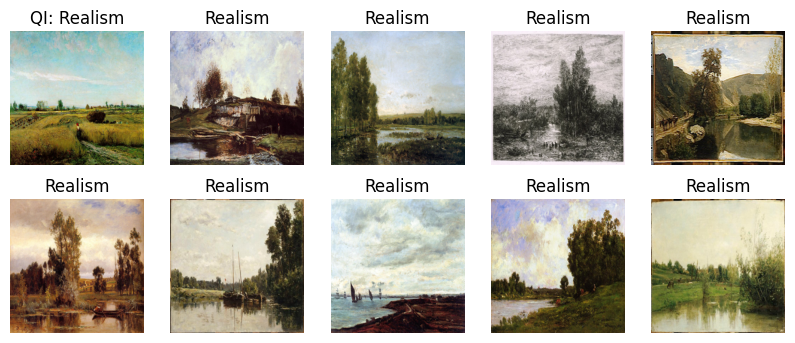

In [49]:
def show_result(similar_images, query_image):
    k = len(similar_images)

    # Crear una figura y subgráficas (subplots)
    fig, axes = plt.subplots(2, int((k + 1)/2), figsize=(10, 4))

    axes = axes.flatten()

    # Plotear la imagen de consulta
    axes[0].imshow(query_image)
    axes[0].set_title("QI: " + os.listdir(test_dir)[query_index].split('-')[1].split('.')[0])
    axes[0].axis('off')

    # Plotear las imágenes más similares
    for i, sim_img in enumerate(similar_images):
        axes[i + 1].imshow(sim_img)
        img_name = Path(df['image'][indices[0][i]]).name.split('-')[1].split('.')[0]  
        axes[i + 1].set_title(img_name)
        axes[i + 1].axis('off')

    plt.show()

show_result(nearest_images, query_image)